In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
import nxpd
from skimage import filters

nxpd.nxpdParams['show'] = 'ipynb'

In [3]:
CODE_DIR = os.path.abspath('..')
sys.path.append(os.path.join(CODE_DIR, 'VisionCG'))
sys.path.append(os.path.join(CODE_DIR, 'EPypes'))

In [4]:
from visioncg import regions, lines, edges, io, improc, viz, corners, nputil, circles

## Connected components

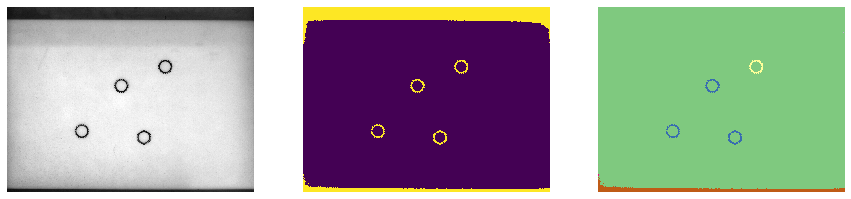

In [5]:
im_swfeeder = io.open_image('sw_on_feeder.png', read_flag=cv2.IMREAD_GRAYSCALE)
swfeeder_t = regions.threshold_binary_inv(im_swfeeder, 150)

swfeeder_labels, swfeeder_ccomp_df = regions.find_ccomp(swfeeder_t)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(im_swfeeder, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(swfeeder_t)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(swfeeder_labels, cmap='Accent')
_ = plt.axis('off')

In [6]:
swfeeder_ccomp_df.sort_values(['width', 'height'], ascending=False)

,left,top,width,height,area,x,y
0,0,54,1024,702,705118,511.964202,405.121706
1,0,0,1024,154,60615,520.164085,30.235255
75,0,706,1024,62,16170,462.036611,758.956277
53,538,512,60,60,1026,566.679337,540.241715
46,626,219,60,59,1135,655.644053,247.258150
51,444,298,60,59,1099,473.878071,326.393085
52,280,486,60,59,1084,309.795203,515.610701
54,588,557,5,4,12,590.000000,558.500000
55,583,562,4,4,12,584.666667,563.666667
22,1011,102,3,4,10,1012.000000,103.200000


## Filtering of the target connected components

In [7]:
def filter_ccomp(df, min_sz=10, tol=0.2):
    
    sz_mean = 0.5 * (df['width'] + df['height'])
    wh_ratio = df['width'] / df['height']
    wh_deviation = np.abs(wh_ratio - 1.)
    
    return df[(wh_deviation <= tol) & (sz_mean >= min_sz)]

In [8]:
df_filtered = filter_ccomp(swfeeder_ccomp_df)

df_filtered

,left,top,width,height,area,x,y
46,626,219,60,59,1135,655.644053,247.258150
51,444,298,60,59,1099,473.878071,326.393085
52,280,486,60,59,1084,309.795203,515.610701
53,538,512,60,60,1026,566.679337,540.241715


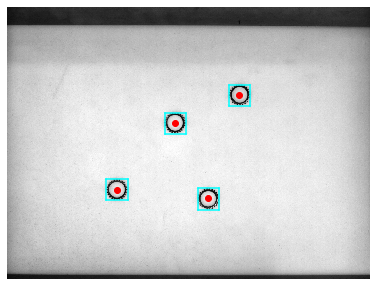

In [9]:
plt.figure(figsize=(10, 5))
plt.imshow(im_swfeeder, cmap='gray')
plt.axis('off')

plt.scatter(df_filtered.x, df_filtered.y, color='r')

for i in range(len(df_filtered)):
    row = df_filtered.iloc[i]
    
    viz.plot_bbox(row.left, row.top, row.width, row.height)